<a href="https://colab.research.google.com/github/semenko/liquid-cell-atlas/blob/main/data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Necessary Libraries

In [1]:
!pip install pyBigWig pybedtools gunzip bedparse deeptools pyGenomeTracks
!apt install bedtools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 976 kB/s 
     |████████████████████████████████| 12.5 MB 23.4 MB/s 
     |████████████████████████████████| 233 kB 39.7 MB/s 
     |████████████████████████████████| 112 kB 44.1 MB/s 
     |████████████████████████████████| 15.1 MB 40.7 MB/s 
     |████████████████████████████████| 51 kB 679 kB/s 
     |████████████████████████████████| 11.2 MB 15.9 MB/s 
     |████████████████████████████████| 41 kB 132 kB/s 
     |████████████████████████████████| 944 kB 45.1 MB/s 
     |████████████████████████████████| 3.2 MB 38.2 MB/s 
     |████████████████████████████████| 100 kB 5.1 MB/s 
     |████████████████████████████████| 121 kB 50.2 MB/s 
     |████████████████████████████████| 84 kB 2.1 MB/s 
     |████████████████████████████████| 90 kB 7.0 MB/s 
     |████████████████████████████████| 829 kB 45.0 MB/s 
     |████████████████████████████████|

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  bedtools
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 577 kB of archives.
After this operation, 2,040 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 bedtools amd64 2.26.0+dfsg-5 [577 kB]
Fetched 577 kB in 1s (919 kB/s)
Selecting previously unselected package bedtools.
(Reading database ... 155653 files and directories currently installed.)
Preparing to unpack .../bedtools_2.26.0+dfsg-5_amd64.deb ...
Unpacking bedtools (2.26.0+dfsg-5) ...
Setting up bedtools (2.26.0+dfsg-5) ...


In [2]:
import pandas as pd
from google.colab import files
import io
import json
import itertools
import numpy as np
import altair as alt
from tqdm.notebook import tqdm
import csv
import os
import urllib
import pandas as pd
from altair import data_transformers
import pickle
from IPython.display import Image
from google.colab import drive

import pyBigWig
import pybedtools

drive.mount("/content/drive")

Mounted at /content/drive


# Get TSV of all data from Blueprint, Filter and Download it

In [3]:
# Download the TSV file from http://dcc.blueprint-epigenome.eu/#/files, and upload it here
# file = files.upload()
! wget 'http://dcc.blueprint-epigenome.eu/data/blueprint_files.tsv'
data_tsv = pd.read_csv('blueprint_files.tsv', sep='\t')

--2022-07-25 03:10:34--  http://dcc.blueprint-epigenome.eu/data/blueprint_files.tsv
Resolving dcc.blueprint-epigenome.eu (dcc.blueprint-epigenome.eu)... 193.62.192.83, 193.62.193.83
Connecting to dcc.blueprint-epigenome.eu (dcc.blueprint-epigenome.eu)|193.62.192.83|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4341342 (4.1M) [text/tab-separated-values]
Saving to: ‘blueprint_files.tsv’

blueprint_files.tsv 100%[===================>]   4.14M  1.22MB/s    in 3.4s    

2022-07-25 03:10:38 (1.22 MB/s) - ‘blueprint_files.tsv’ saved [4341342/4341342]



Filtering the tsv file to get rid of individuals with diseases, and only keeping the bigWig file format. We also only keep bisulfite sequencing data.

In [4]:
noDisease_bw_data = data_tsv[(data_tsv['Disease'] == 'None') & 
                             (data_tsv['Format'] == 'bigWig') & 
                             (data_tsv['Experiment'] == 'Bisulfite-Seq')]

Types of cells present in the dataset. For now, I'll choose a macrophage sample, and a plasma cell

In [5]:
cell_types = noDisease_bw_data['Cell type'].unique()
cell_types

array(['band form neutrophil', 'neutrophilic metamyelocyte',
       'neutrophilic myelocyte', 'segmented neutrophil of bone marrow',
       'hematopoietic multipotent progenitor cell', 'precursor B cell',
       'precursor lymphocyte of B lineage', 'plasma cell',
       'mature neutrophil', 'CD38-negative naive B cell',
       'CD14-positive, CD16-negative classical monocyte',
       'CD8-positive, alpha-beta T cell',
       'cytotoxic CD56-dim natural killer cell',
       'inflammatory macrophage', 'erythroblast',
       'CD34-negative, CD41-positive, CD42-positive megakaryocyte cell',
       'macrophage', 'endothelial cell of umbilical vein (proliferating)',
       'endothelial cell of umbilical vein (resting)',
       'alternatively activated macrophage',
       'conventional dendritic cell',
       'CD3-negative, CD4-positive, CD8-positive, double positive thymocyte',
       'CD3-positive, CD4-positive, CD8-positive, double positive thymocyte',
       'CD4-positive, alpha-beta thym

Get example of macrophage and plasma data, and extract its url.

In [6]:
cell_type_1 = 'macrophage'
cell_type_2 = 'plasma cell'

assert cell_type_1 in cell_types, "{} not a valid cell type".format(cell_type_1)
assert cell_type_2 in cell_types, "{} not a valid cell type".format(cell_type_2)

cell1_data = noDisease_bw_data[noDisease_bw_data['Cell type'] == cell_type_1]
cell2_data = noDisease_bw_data[noDisease_bw_data['Cell type'] == cell_type_2]

cell1_call = cell1_data.iloc[0]
cell1_cov = cell1_data.iloc[1]
cell2_call = cell2_data.iloc[0]
cell2_cov = cell2_data.iloc[1]

cell1_call_url = cell1_call['URL']
cell1_cov_url = cell1_cov['URL']
cell2_call_url = cell2_call['URL']
cell2_cov_url = cell2_cov['URL']

cell1_call_filename = cell1_call_url.split("/")[-1]
cell1_cov_filename = cell1_cov_url.split("/")[-1]
cell2_call_filename = cell2_call_url.split("/")[-1]
cell2_cov_filename = cell2_cov_url.split("/")[-1]

Downloading the data at the four URLs! This will take around 10 minutes.

In [7]:
! wget '$cell1_call_url'
! wget '$cell1_cov_url'
! wget '$cell2_call_url'
! wget '$cell2_cov_url'

--2022-07-25 03:10:38--  http://ftp.ebi.ac.uk/pub/databases/blueprint/data/homo_sapiens/GRCh38/cord_blood/S00BHQ/macrophage/Bisulfite-Seq/CNAG/S00BHQ51.CPG_methylation_calls.bs_call.GRCh38.20160531.bw
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.138|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125016699 (119M) [application/octet-stream]
Saving to: ‘S00BHQ51.CPG_methylation_calls.bs_call.GRCh38.20160531.bw’

S00BHQ51.CPG_methyl   0%[                    ]       0  --.-KB/s    in 15m 0s  

2022-07-25 03:25:39 (0.00 B/s) - Read error at byte 0/125016699 (Connection timed out). Retrying.

--2022-07-25 03:25:40--  (try: 2)  http://ftp.ebi.ac.uk/pub/databases/blueprint/data/homo_sapiens/GRCh38/cord_blood/S00BHQ/macrophage/Bisulfite-Seq/CNAG/S00BHQ51.CPG_methylation_calls.bs_call.GRCh38.20160531.bw
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.138|:80... connected.
HTTP request sent, awaiti

In [8]:
# Annotations & bs_cov / bs_call names
CELL_TYPE_TO_FILE_ID = {
    "Macrophage": ["S00BHQ51"],
    "Plasma_cell": ["G202"]
}

# Reverse mapping of file id -> cell type
# e.g.  'S01BHIA1': 'Monocyte'
FILE_ID_TO_CELL_TYPE = {sample:cell_type for cell_type, sample_list in CELL_TYPE_TO_FILE_ID.items() for sample in sample_list}

# If the blueprint dict changes, we need to replace our cache files
# This is a tiny checksum of the dictionary state, which we incorporate into
# our cache filenames below.
CELL_TYPE_DICT_SIG = str(hex(abs(hash(json.dumps(CELL_TYPE_TO_FILE_ID, sort_keys=True))))[2:10])
print(f"Dictionary signature for cache files: {CELL_TYPE_DICT_SIG}\n")


BLUEPRINT_FILEKEYS = list(itertools.chain.from_iterable(CELL_TYPE_TO_FILE_ID.values()))

# Validity testing
# assert all(len(vals) > 1 for vals in CELL_TYPE_TO_FILE_ID.values()), "We need more than one example per cell type."
assert len(BLUEPRINT_FILEKEYS) == len(set(BLUEPRINT_FILEKEYS)), "One filename is duplicated in the cell types"

print(f"Number of Blueprint cell types: {len(CELL_TYPE_TO_FILE_ID.keys())}")
print(f"Number of Blueprint raw files: {len(BLUEPRINT_FILEKEYS)}")

CHROMOSOMES = ["chr" + str(i) for i in range(1, 23)] + ["chrX"]
CHROMOSOMES = ["chr7", "chr17"]

Dictionary signature for cache files: 76de60e0

Number of Blueprint cell types: 2
Number of Blueprint raw files: 2


# Create shared **cov** map

Load coverage (if >minimum below) across all files, then determine the set() shared across **all** samples.

IF a locus (e.g. "chr1:123") is missing from **one** single sample, it will be **excluded** from our entire analysis.

IF a locus has \<20 reads in **one** single sample, it will be **excluded** from our entire analysis.

In [9]:
IGNORE_CACHE = False

BLUEPRINT_CPG_COV_MINIMUM = 10

RUN_SIGNATURE = f"{BLUEPRINT_CPG_COV_MINIMUM}_{CELL_TYPE_DICT_SIG}"

assert type(BLUEPRINT_CPG_COV_MINIMUM) is int
assert BLUEPRINT_CPG_COV_MINIMUM > 0

print(f"Minimum Blueprint coverage limit: {BLUEPRINT_CPG_COV_MINIMUM}")
print(f" (CpGs with fewer than {BLUEPRINT_CPG_COV_MINIMUM} reads in *any* sample will be ignored.)\n")

# Our output / save file
INTERSECTED_COVERAGE_BED = f"intersected_bs_cov_min_{RUN_SIGNATURE}.bed"
CLEAN_INTERSECTED_COVERAGE_BED = f"intersected_bs_cov_min_{RUN_SIGNATURE}_clean.bed"

print(f"Coverage BED: {INTERSECTED_COVERAGE_BED}")

if os.path.exists(INTERSECTED_COVERAGE_BED) and not IGNORE_CACHE:
    print("\tPost-processed cov .bed already exists. (Skipping raw Blueprint bs_cov parsing.)")
else:
    print("\t.bed does not exist yet -- parsing bs_cov .bw files.")
    INTERSECTED_BS_COV_POSITIONS = {}
    MAX_CHROMOSOME_SIZE = {}

    for file_key in tqdm(BLUEPRINT_FILEKEYS):
        with pyBigWig.open(file_key + ".CPG_methylation_calls.bs_cov.GRCh38.20160531.bw") as bw_object:
            bw_header = bw_object.header()
            if bw_header['nBasesCovered'] < 1e7 or bw_header['sumData'] < 1e8:
                print('\t\t*** WARNING: Input .bw has few reads or low coverage. This may cause unexpected results, consider removing this file.')
                print(f"\t\tnBasesCovered: {bw_header['nBasesCovered']}, sumData: {bw_header['sumData']}")
            for chrom in CHROMOSOMES:
                current_loop_values = set([start for start, _, cov in bw_object.intervals(chrom) if cov >= BLUEPRINT_CPG_COV_MINIMUM])
                MAX_CHROMOSOME_SIZE[chrom] = np.max(list(current_loop_values))
                existing_values = INTERSECTED_BS_COV_POSITIONS.get(chrom, current_loop_values)
                INTERSECTED_BS_COV_POSITIONS[chrom] = existing_values.intersection(current_loop_values)
            # print(track)

    # Save this hard work as a .bed for later recovery if needed
    with open(INTERSECTED_COVERAGE_BED, 'w') as outfile:
        # A .bed is just a .tsv with ['chrom', 'chromStart', 'chromEnd']
        bed_writer = csv.writer(outfile, delimiter='\t')
        for chr in CHROMOSOMES:
            for entry in INTERSECTED_BS_COV_POSITIONS[chr]:
                bed_writer.writerow([chr, entry, entry+1])

    print(f"\nWrote data to: {INTERSECTED_COVERAGE_BED}") # Unsorted

! cat {INTERSECTED_COVERAGE_BED} | tr -d '\r' > {CLEAN_INTERSECTED_COVERAGE_BED}

Minimum Blueprint coverage limit: 10
 (CpGs with fewer than 10 reads in *any* sample will be ignored.)

Coverage BED: intersected_bs_cov_min_10_76de60e0.bed
	.bed does not exist yet -- parsing bs_cov .bw files.


  0%|          | 0/2 [00:00<?, ?it/s]


Wrote data to: intersected_bs_cov_min_10_76de60e0.bed


# Removing ENCODE Regions

Encode defines a standard list of "bad" regions -- very low complexity / information content, etc. that show up in some studies but are not informative. We remove them and do some other standard data cleaning.

In [10]:
# Load the .bed from above
raw_bs_cov_bed = pybedtools.BedTool(CLEAN_INTERSECTED_COVERAGE_BED)
print(f"Number of entries in bs_cov (raw): {len(raw_bs_cov_bed):,}")

if not os.path.exists("ENCFF356LFX.bed.gz"):
    print("Downloading ENCODE DAC Exclusion List")
    urllib.request.urlretrieve("https://www.encodeproject.org/files/ENCFF356LFX/@@download/ENCFF356LFX.bed.gz", "ENCFF356LFX.bed.gz")

! gunzip ENCFF356LFX.bed.gz
excluded_regions = pybedtools.BedTool("ENCFF356LFX.bed")
print(f"Number of entries in excluded_regions: {len(excluded_regions):,}")
assert len(excluded_regions) > 900 # 910 as of 1/2022

# .saveas forces this to render, otherwise may be a generator
# TODO: Fix path to be more specific
cleaned_sorted_bs_cov = raw_bs_cov_bed.subtract(excluded_regions).sort().saveas('bs_cov_cleaned_sorted.bed')
print(f"Number of remaining bs_cov entries: {len(cleaned_sorted_bs_cov):,}")
# assert len(cleaned_sorted_bs_cov) > 90000 # We expect about 90k entries


# Convert `bs_cov_cleaned_sorted` to a dict too:
#  key: chr
#  val: [sorted list of bs_cov positions]
# NOTE: This works because dicts are insertion ordered as of Python>3.7
BS_COV_POSITIONS = {}
for bed_entry in cleaned_sorted_bs_cov:
    BS_COV_POSITIONS.setdefault(bed_entry.chrom, []).append(bed_entry.start)

Number of entries in bs_cov (raw): 1,940,103
Number of entries in excluded_regions: 910
Number of remaining bs_cov entries: 1,926,990


# Load bs_call data

In [11]:
FILE_ID_TO_CPG_CALLS = { }

# cache_file = "bs_call_min_" + str(BLUEPRINT_CPG_COV_MINIMUM) + ".json"
print("Parsing bs_call files.")
for file_key in tqdm(BLUEPRINT_FILEKEYS):
    print(f"{file_key}")
    FILE_ID_TO_CPG_CALLS[file_key] = {}
    with pyBigWig.open(file_key + ".CPG_methylation_calls.bs_call.GRCh38.20160531.bw") as bw_object:
        for chrom in CHROMOSOMES:
            # This is more nuanced than the bs_cov data, since we only want to look at the 
            # CpGs that were covered across all samples. (The intervals now in BS_COV_POSITIONS).

            # Each .bw interval is a nested tuple of: ((start, end, value))
            # We extract all the values that overlap our bs_cov set.
            # FILE_ID_TO_CPG_CALLS[file_key][chrom] = [bw_object.intervals(chrom, pos, pos+1)[0][2] for pos in INTERSECTED_BS_COV_POSITIONS[chrom]]
            temp = []
            for pos in BS_COV_POSITIONS[chrom]:
                temp.append(bw_object.intervals(chrom, pos, pos+1)[0][2])
                FILE_ID_TO_CPG_CALLS[file_key][chrom] = temp

SCALED_BS_COV_POSITIONS = {}
for chrom in CHROMOSOMES:
    SCALED_BS_COV_POSITIONS[chrom] = np.array(BS_COV_POSITIONS[chrom]) / MAX_CHROMOSOME_SIZE[chrom]

Parsing bs_call files.


  0%|          | 0/2 [00:00<?, ?it/s]

S00BHQ51
G202


# Checkpoint: Download the Relevant Files

We are using pickle to dump and load the dictionaries for the locations, scaled locations, and the methylation calls!

In [ ]:
pickle.dump(SCALED_BS_COV_POSITIONS, open("scaled_bs_cov_positions.p", "wb"))
pickle.dump(FILE_ID_TO_CPG_CALLS, open("file_id_to_cpg_calls.p", "wb"))
pickle.dump(BS_COV_POSITIONS, open("bs_cov_positions.p", "wb"))

files.download("scaled_bs_cov_positions.p")
files.download("file_id_to_cpg_calls.p")
files.download("bs_cov_positions.p")

NameError: ignored

In [21]:
# files.download("S00BHQ51.CPG_methylation_calls.bs_call.GRCh38.20160531.bw")
files.download("S00BHQ51.CPG_methylation_calls.bs_cov.GRCh38.20160531.bw")
files.download("G202.CPG_methylation_calls.bs_call.GRCh38.20160531.bw")
files.download("G202.CPG_methylation_calls.bs_cov.GRCh38.20160531.bw")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Upload the files into your Google Drive. I put them in the main directory, although you could put them somewhere else. Just change the path below to wherever the file is!

In [16]:
SCALED_BS_COV_POSITIONS = pickle.load(open("/content/drive/My Drive/scaled_bs_cov_positions.p", "rb"))
FILE_ID_TO_CPG_CALLS = pickle.load(open("/content/drive/My Drive/file_id_to_cpg_calls.p", "rb"))
BS_COV_POSITIONS = pickle.load(open("/content/drive/My Drive/bs_cov_positions.p", "rb"))

In [17]:
with open("bs_cov_cleaned_sorted.bed", 'w') as outfile:
    # A .bed is just a .tsv with ['chrom', 'chromStart', 'chromEnd']
    bed_writer = csv.writer(outfile, delimiter='\t')
    for chr in CHROMOSOMES:
        for entry in BS_COV_POSITIONS[chr]:
            bed_writer.writerow([chr, entry, entry+1])

# Visualize the Methylation Data

We create a Pandas dataframe with columns for cell type, location, and corresponding methylation! This way, we can plot the location on the chromosome vs methylation for different cell types.

Every 5000 rows was averaged in order to generage a readable graph, as there are millions of data points, and plotting all of them results in a line chart too dense to make sense of.

In [ ]:
line_df = pd.DataFrame(columns = ["cell type", "location_percent", "methylation"])

CHROMOSOMES = ["chr1"]

for file_key in BLUEPRINT_FILEKEYS:
    for chrom in CHROMOSOMES:
        lengt = len(SCALED_BS_COV_POSITIONS[chrom])
        temp = [[(SCALED_BS_COV_POSITIONS[chrom])[i], (FILE_ID_TO_CPG_CALLS[file_key][chrom])[i]] for i in range(lengt)]
        temp_df = pd.DataFrame(temp, columns = ["location_percent", "methylation"])
        temp_df_avg = temp_df.groupby(np.arange(len(temp_df))//5000).mean()
        temp_df_avg["cell type"] = FILE_ID_TO_CELL_TYPE[file_key]
        line_df = pd.concat([line_df, temp_df_avg], axis=0)

In [ ]:
alt.data_transformers.enable('default', max_rows=None)

alt.Chart(line_df).mark_line().encode(
    x='location_percent',
    y='methylation',
    color='cell type'
)

alt.Chart(...)

# Getting Methylation for Gene Promoters

Download the genomic database and convert it into a bed file.

In [22]:
! wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_40/gencode.v40.annotation.gtf.gz
! gunzip gencode.v40.annotation.gtf.gz
! bedparse gtf2bed <gencode.v40.annotation.gtf> output.bed --extraFields gene_id,gene_name
output_bed = pybedtools.BedTool("output.bed")

--2022-07-25 06:27:08--  https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_40/gencode.v40.annotation.gtf.gz
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48043727 (46M) [application/octet-stream]
Saving to: ‘gencode.v40.annotation.gtf.gz’

gencode.v40.annotat   0%[                    ]       0  --.-KB/s    in 15m 0s  

2022-07-25 06:42:09 (0.00 B/s) - Read error at byte 0/48043727 (Connection timed out). Retrying.

--2022-07-25 06:42:10--  (try: 2)  https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_40/gencode.v40.annotation.gtf.gz
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48043727 (46M) [application/octet-stream]
Saving to: ‘gencode.v40.annotation.gtf.gz’

gencode.v40.annotat 100%[===================>]  45.82M  1.37MB/s   

Convert the bed file into a pandas dataframe, and remove any unneccessary colummns! The only ones we keep are those relating to the chromosome number, the start and end base pair, the strandedness, the gene_id, and gene_name!

In [24]:
gene_loc = pd.read_csv("output.bed", sep = '\t', names = ["chrom", "start", "end", "name", "e1", "strand", "e2", "e3", "e4", "e5", "e6", "e7", "gene_id", "gene_name"])
gene_loc = gene_loc[["chrom", "start", "end", "strand", "gene_id", "gene_name"]]

We can make another bed file with the gene locations, but with padding, for the purposes of creating a heatmap later!

In [35]:
padding = int(input("How many base pairs do you want around the gene locations? "))

with open("gene_locs.bed", 'w') as outfile:
    # A .bed is just a .tsv with ['chrom', 'chromStart', 'chromEnd']
    bed_writer = csv.writer(outfile, delimiter='\t')
    for chr in CHROMOSOMES:
        for index, row in gene_loc.iterrows():
            if row["chrom"] == "chr1":
                bed_writer.writerow([row["chrom"], row["start"] - padding, row["end"] + padding])

How many base pairs do you want around the gene locations? 1000


In [36]:
genes = {"ACTB": "ENSG00000075624", "UBB": "ENSG00000170315"}
promoter_loc = {}
gene_chr = {}

for gene in genes.keys():
    gene_location = gene_loc[gene_loc["gene_id"].str.contains(genes[gene])].iloc[0]
    promoter = (gene_location["end"], gene_location["end"] + 500)
    promoter_loc[gene] = promoter
    gene_chr[gene] = gene_location["chrom"]

In [27]:
promoter_cov = {}
for gene in genes.keys():
    cov = [x for x in list(range(promoter_loc[gene][0], promoter_loc[gene][1])) if x in BS_COV_POSITIONS[gene_chr[gene]]]
    promoter_cov[gene] = cov

indeces = [BS_COV_POSITIONS[gene_chr["ACTB"]].index(i) for i in promoter_cov["ACTB"]]

# gene_methylation = {}
# for gene in genes.key():
#     methylation = [FILE_ID_TO_CPG_CALLS[gene_chr[gene]][promoter_cov[gene].index(x)] for x in promoter_cov[gene]]
    
# methylation = [FILE_ID_TO_CPG_CALLS["chr7"][promoter_loc.index(x)] for x in promoter_loc]

In [28]:
line_df = pd.DataFrame(columns = ["cell type", "location", "methylation"])

for file_key in BLUEPRINT_FILEKEYS:
    for chrom in CHROMOSOMES:
        lengt = len(promoter_cov["ACTB"])
        temp = [[promoter_cov["ACTB"][i], (FILE_ID_TO_CPG_CALLS[file_key][chrom])[indeces[i]]] for i in range(lengt)]
        temp_df = pd.DataFrame(temp, columns = ["location", "methylation"])
        temp_df["cell type"] = FILE_ID_TO_CELL_TYPE[file_key]
        line_df = pd.concat([line_df, temp_df], axis=0)

In [29]:
alt.data_transformers.enable('default', max_rows=None)

alt.Chart(line_df).mark_line().encode(
    x='location',
    y='methylation',
    color='cell type'
)

alt.Chart(...)

# Plotting a Heatmap

In [43]:
! computeMatrix scale-regions -S "S00BHQ51.CPG_methylation_calls.bs_call.GRCh38.20160531.bw" \
      -R gene_locs.bed \
      --beforeRegionStartLength 1000 \
      --regionBodyLength 5000 \
      --afterRegionStartLength 1000 \
      --skipZeros -o S00BHQ51_2.mat.gz \

Skipping chr1:64418-72585, due to being absent in the computeMatrix output.
Skipping chr1:449739-452678, due to being absent in the computeMatrix output.
Skipping chr1:804798-811161, due to being absent in the computeMatrix output.
Skipping chr1:13060157-13063878, due to being absent in the computeMatrix output.
Skipping chr1:13127817-13132615, due to being absent in the computeMatrix output.
Skipping chr1:13128792-13132409, due to being absent in the computeMatrix output.
Skipping chr1:13195187-13202409, due to being absent in the computeMatrix output.
Skipping chr1:13195329-13199130, due to being absent in the computeMatrix output.
Skipping chr1:13302538-13309907, due to being absent in the computeMatrix output.
Skipping chr1:16665784-16667948, due to being absent in the computeMatrix output.
Skipping chr1:16739515-16741679, due to being absent in the computeMatrix output.
Skipping chr1:103624637-103626656, due to being absent in the computeMatrix output.
Skipping chr1:103655017-1036

In [44]:
! plotHeatmap -m S00BHQ51_2.mat.gz \
      -out S00BHQ51_2.png \

In [45]:
# files.download("S00BHQ51_2.png")
Image("S00BHQ51_2.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Coverage Plots

In [3]:
# Upload bw coverage files
files.upload()
files.upload()

Saving G202.CPG_methylation_calls.bs_cov.GRCh38.20160531.bw to G202.CPG_methylation_calls.bs_cov.GRCh38.20160531.bw


Saving S00BHQ51.CPG_methylation_calls.bs_cov.GRCh38.20160531.bw to S00BHQ51.CPG_methylation_calls.bs_cov.GRCh38.20160531.bw


In [6]:
# Upload .ini file
files.upload()

Saving bigwig_cov.ini to bigwig_cov.ini


{'bigwig_cov.ini': b'[test bigwig]\r\nfile = S00BHQ51.CPG_methylation_calls.bs_cov.GRCh38.20160531.bw\r\ncolor = (0.6, 0, 0)\r\nalpha = 0.5\r\n# height of the track in cm (optional value)\r\nheight = 7\r\ntitle = bigwig\r\nmin_value = 0\r\nmax_value = 100\r\n\r\n[test bigwig]\r\nfile = G202.CPG_methylation_calls.bs_cov.GRCh38.20160531.bw\r\ncolor = green\r\nalpha = 0.5\r\nheight = 7\r\nmin_value = 0\r\nmax_value = 100\r\noverlay_previous = share-y\r\n'}

INFO:pygenometracks.tracksClass:initialize 1. [test bigwig]
INFO:pygenometracks.tracksClass:initialize 2. [test bigwig]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.0015044212341308594
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 7.446808510638299. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [test bigwig]
INFO:pygenometracks.tracksClass:plotting 2. [test bigwig]


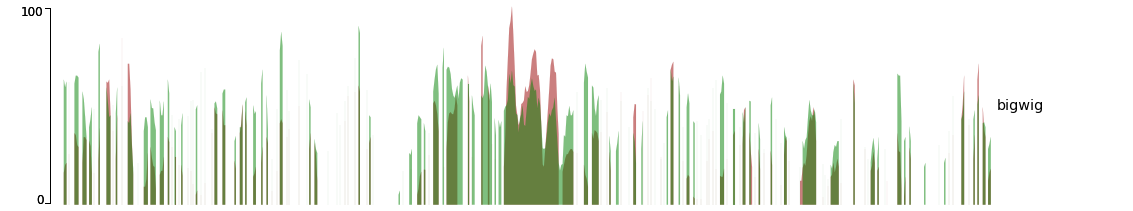

In [7]:
! pyGenomeTracks --tracks 'bigwig_cov.ini' --region 7:5,520,000-5,540,000 -o bigwig.png
# files.download("bigwig.png")
Image("bigwig.png")

# Metilene

In [9]:
! wget http://www.bioinf.uni-leipzig.de/Software/metilene/metilene_v02-5.tar.gz

--2022-07-25 18:54:44--  http://www.bioinf.uni-leipzig.de/Software/metilene/metilene_v02-5.tar.gz
Resolving www.bioinf.uni-leipzig.de (www.bioinf.uni-leipzig.de)... 139.18.75.66
Connecting to www.bioinf.uni-leipzig.de (www.bioinf.uni-leipzig.de)|139.18.75.66|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2125946 (2.0M) [application/x-gzip]
Saving to: ‘metilene_v02-5.tar.gz’

metilene_v02-5.tar. 100%[===================>]   2.03M  1.43MB/s    in 1.4s    

2022-07-25 18:54:46 (1.43 MB/s) - ‘metilene_v02-5.tar.gz’ saved [2125946/2125946]



In [14]:
! tar -xvzf metilene_v02-5.tar.gz

metilene_v0.2-5/
metilene_v0.2-5/metilene_linux64
metilene_v0.2-5/src/
metilene_v0.2-5/src/vstack.c
metilene_v0.2-5/src/708.h
metilene_v0.2-5/src/info.h
metilene_v0.2-5/src/metseg.h
metilene_v0.2-5/src/debug.h
metilene_v0.2-5/src/manopt.h
metilene_v0.2-5/src/mathematics.c
metilene_v0.2-5/src/info.c
metilene_v0.2-5/src/manopt.c
metilene_v0.2-5/src/stringutils.h
metilene_v0.2-5/src/metseg.c
metilene_v0.2-5/src/memory.c
metilene_v0.2-5/src/sort.c
metilene_v0.2-5/src/fileio.c
metilene_v0.2-5/src/basic-types.h
metilene_v0.2-5/src/debug.c
metilene_v0.2-5/src/mathematics.h
metilene_v0.2-5/src/memory.h
metilene_v0.2-5/src/stringutils.c
metilene_v0.2-5/src/708.c
metilene_v0.2-5/src/sort.h
metilene_v0.2-5/src/segmentstack.h
metilene_v0.2-5/src/segmentstack.c
metilene_v0.2-5/src/fileio.h
metilene_v0.2-5/src/stack.c
metilene_v0.2-5/src/stack.h
metilene_v0.2-5/src/vstack.h
metilene_v0.2-5/Makefile
metilene_v0.2-5/README
metilene_v0.2-5/metilene_linux32
metilene_v0.2-5/metilene_input.pl
metilene_v0.

In [22]:
%cd "metilene_v0.2-5"

/content/metilene_v0.2-5


In [24]:
! make

gcc -Wall -pedantic -std=c99 -O3 -D_GNU_SOURCE_ -g  -D_LARGEFILE_SOURCE -D_FILE_OFFSET_BITS=64 -DDBGLEVEL=0 -DPROGNFO -I -Lsrc    -c -o src/manopt.o src/manopt.c
gcc -Wall -pedantic -std=c99 -O3 -D_GNU_SOURCE_ -g  -D_LARGEFILE_SOURCE -D_FILE_OFFSET_BITS=64 -DDBGLEVEL=0 -DPROGNFO -I -Lsrc    -c -o src/memory.o src/memory.c
gcc -Wall -pedantic -std=c99 -O3 -D_GNU_SOURCE_ -g  -D_LARGEFILE_SOURCE -D_FILE_OFFSET_BITS=64 -DDBGLEVEL=0 -DPROGNFO -I -Lsrc    -c -o src/debug.o src/debug.c
gcc -Wall -pedantic -std=c99 -O3 -D_GNU_SOURCE_ -g  -D_LARGEFILE_SOURCE -D_FILE_OFFSET_BITS=64 -DDBGLEVEL=0 -DPROGNFO -I -Lsrc    -c -o src/info.o src/info.c
gcc -Wall -pedantic -std=c99 -O3 -D_GNU_SOURCE_ -g  -D_LARGEFILE_SOURCE -D_FILE_OFFSET_BITS=64 -DDBGLEVEL=0 -DPROGNFO -I -Lsrc    -c -o src/stringutils.o src/stringutils.c
gcc -Wall -pedantic -std=c99 -O3 -D_GNU_SOURCE_ -g  -D_LARGEFILE_SOURCE -D_FILE_OFFSET_BITS=64 -DDBGLEVEL=0 -DPROGNFO -I -Lsrc    -c -o src/fileio.o src/fileio.c
src/fileio.c: In functio

In [25]:
! metilene

/bin/bash: metilene: command not found
